In [143]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix 
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.feature_extraction import DictVectorizer

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px


In [2]:
data = pd.read_csv("final_proj_data/contraceptive/contraceptive_for_students.csv")

# Question:
### Stage 1:
Predict whether the woman uses contraceptive methods 

### Stage 2:
For all the women who use the contraceptive methods,
predict the extent the women use the methods


# Helper Function:

In [3]:
def normalize_and_scale(data):
    data_centered_scaled = data - np.mean(data,axis=0)
    data_centered_scaled = data_centered_scaled.div(np.std(data_centered_scaled), axis=1)
    return data_centered_scaled

In [4]:
def plot_first_2_pcas(dat_1st_2_pcs, hue_col):
    sns.scatterplot(data = dat_1st_2_pcs, 
                x = 'pc1', 
                y = 'pc2', 
                hue = hue_col, 
                    palette = "RdBu")
    plt.gca().set_xlim(-10, 10);
    plt.gca().set_ylim(-10, 10);

In [5]:
def plot_first_3_pcas(pcas, hue_col):
    fig = px.scatter_3d(pcas, 
                    x='pc1', y='pc2', z='pc3', 
                    range_x = [-10, 10], 
                    range_y = [-10, 10], 
                    range_z = [-10, 10], 
                    color = hue_col, 
                    color_continuous_scale = 'RdBu');
    fig.show();

In [6]:
def create_jittered_pair_plot(data, selected_cols):
    data_pairplot_jittered = data[selected_cols]
    data_pairplot_jittered = data_pairplot_jittered + np.random.normal(0, 0.15, size = data_pairplot_jittered.shape)
    data_pairplot_jittered["contraceptive"] = data_2["contraceptive"]
    sns.pairplot(data_pairplot_jittered, hue="contraceptive", 
                 vars=selected_cols, 
                 palette="husl", plot_kws={'alpha': 0.5})

In [7]:
def ohe(data, col_name):
    """
    One Hot Encoding of a specified column name
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[[col_name]].to_dict(orient='records'))
    targeted_col_data = vec_enc.transform(data[[col_name]].to_dict(orient='records')).toarray()
    targeted_col_cats = vec_enc.get_feature_names()
    targeted_col = pd.DataFrame(targeted_col_data, columns=targeted_col_cats)
    data = pd.concat([data, targeted_col], axis=1)
    return data

In [158]:
def plot_confusion_matrix(y_true, y_pred, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input:
        y_true: list, the true label of the test set 
        y_pred: list, the predicted label of the test set 
        labels: list of string, the name for your labels
        normalize: boolean, whether you want a normalized confusion matrix,
                   default is False
        cmap: the color of your confusion matrix plot 
    
    Output:
        the figure of your plot
        (Reminder: After you have called this fuction, you have called 
        plt.show() to show the plot)
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# EDA:

In [8]:
# check missing values 
data.isna().sum()

wife_age              0
wife_education        0
husband_education     0
num_child             0
wife_religion         0
wife_work             0
husband_occupation    0
standard_living       0
media_exposure        0
contraceptive         0
dtype: int64

In [9]:
data['contraceptive'].replace({1: 0, 2: 1, 3: 2}, inplace=True)

In [10]:
# train_test_split
X = data.drop('contraceptive', axis=1)
Y = data['contraceptive']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, 
                                                  random_state=110)

In [11]:
train_centered_scaled = normalize_and_scale(X_train)

In [12]:
u, s, vt = np.linalg.svd(train_centered_scaled, full_matrices = False)

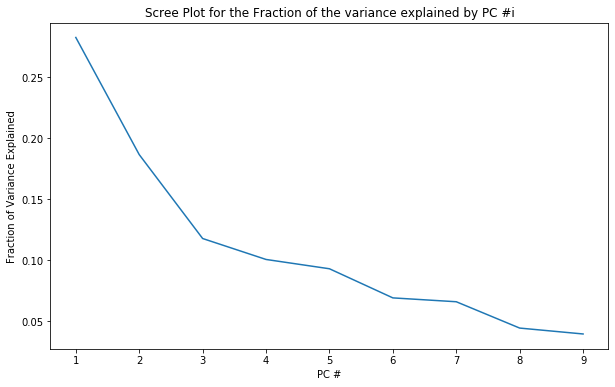

In [13]:
figure(figsize=(10,6))
xx = list(range(1, s.shape[0]+1))
plt.plot(xx, s**2 / sum(s**2));
plt.xticks(xx, xx);
plt.xlabel('PC #');
plt.ylabel('Fraction of Variance Explained')
plt.title("Scree Plot for the Fraction of the variance explained by PC #i");

In [14]:
pcs = train_centered_scaled@vt.T
dat_3_pcs_scaled = pd.DataFrame({'pc1': pcs.iloc[:,0], 'pc2':  pcs.iloc[:,1],
                                     'pc3': pcs.iloc[:,2],
                                    'contraceptive':Y_train})

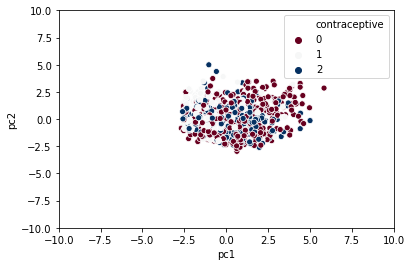

In [15]:
plot_first_2_pcas(dat_3_pcs_scaled, "contraceptive")

In [16]:
plot_first_3_pcas(dat_3_pcs_scaled, "contraceptive")

### redefine the categories of y

In [22]:
data_2 = data.copy()
data_2['contraceptive'] = data['contraceptive'].replace({2: 1})

In [23]:
# train_test_split
X_2 = data_2.drop('contraceptive', axis=1)
Y_2 = data_2['contraceptive']
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2,Y_2, test_size=0.25, 
                                                  random_state=110)
print("Training Data Size:", {len(X_train_2)})
print("Test Data Size:", {len(X_test_2)})

Training Data Size: {1104}
Test Data Size: {369}


In [24]:
train_2 = X_train_2.copy()
train_2['contraceptive'] = Y_train_2

In [25]:
train_centered_scaled_2 = normalize_and_scale(X_train_2)

In [26]:
u_2, s_2, vt_2 = np.linalg.svd(train_centered_scaled_2, full_matrices = False)
pcs_2 = train_centered_scaled_2@vt_2.T
dat_3_pcs_scaled_2 = pd.DataFrame({'pc1': pcs_2.iloc[:,0], 'pc2':  pcs_2.iloc[:,1],
                                     'pc3': pcs_2.iloc[:,2],
                                    'contraceptive':Y_train})

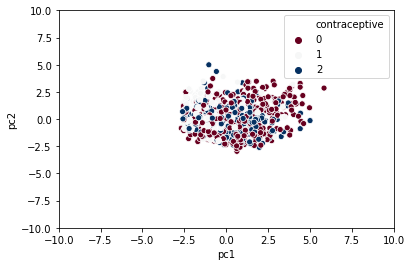

In [27]:
plot_first_2_pcas(dat_3_pcs_scaled_2, "contraceptive")

In [28]:
plot_first_3_pcas(dat_3_pcs_scaled_2, "contraceptive")

### Contraceptive Extend PCA

In [29]:
contra_extend = data.loc[data["contraceptive"] > 0, :]
contra_extend['contraceptive'].replace({1: 0, 2: 1}, inplace=True)

In [30]:
# train_test_split
X_extend = data_2.drop('contraceptive', axis=1)
Y_extend = data_2['contraceptive']
X_train_ex, X_test_ex, Y_train_ex, Y_test_ex = train_test_split(X_extend,Y_extend, test_size=0.25, 
                                                  random_state=110)
print("Training Data Size:", {len(X_train_ex)})
print("Test Data Size:", {len(X_test_ex)})

Training Data Size: {1104}
Test Data Size: {369}


In [31]:
extend_centered_scaled = normalize_and_scale(X_train_ex)

In [32]:
u_extend, s_extend, vt_extend = np.linalg.svd(extend_centered_scaled, full_matrices = False)
pcs_extend = extend_centered_scaled@vt_extend.T
extend_3_pcs_scaled = pd.DataFrame({'pc1': pcs_extend.iloc[:,0], 'pc2':  pcs_extend.iloc[:,1],
                                     'pc3': pcs_extend.iloc[:,2],
                                    'contraceptive':Y_train_ex})

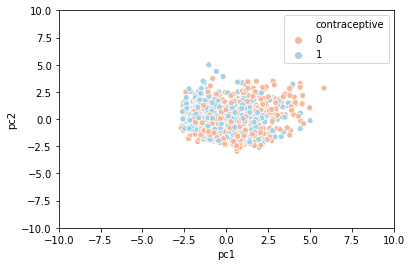

In [33]:
plot_first_2_pcas(extend_3_pcs_scaled, "contraceptive")

In [34]:
plot_first_3_pcas(extend_3_pcs_scaled, "contraceptive")

1. Boxplot 
2. Heatmap
3. Pairplot? 

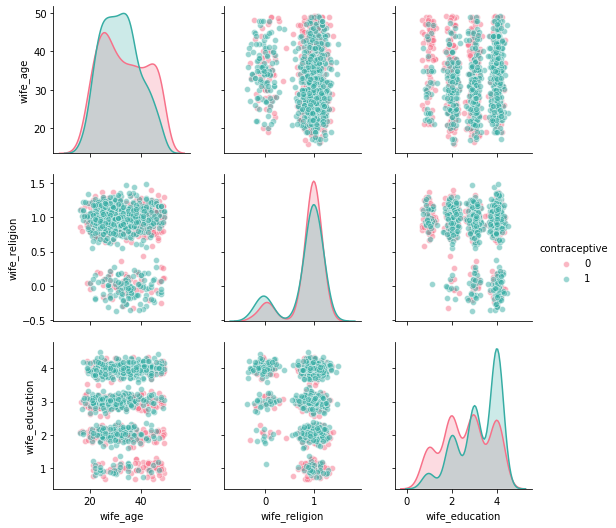

In [35]:
selected_cols_1 = ["wife_age", "wife_religion", "wife_education"]
create_jittered_pair_plot(X_train_2, selected_cols_1)
plt.show();

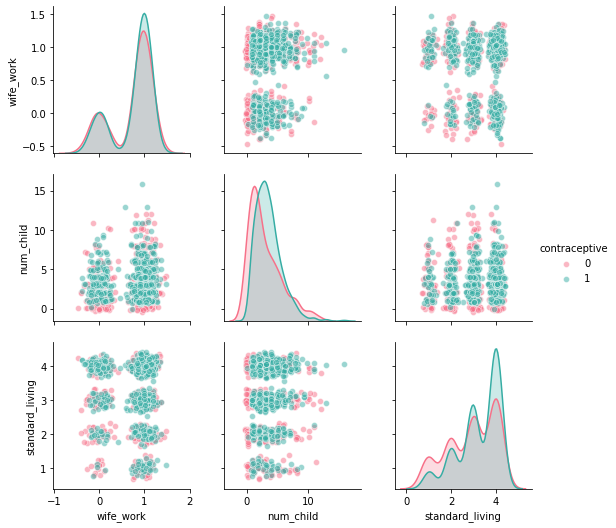

In [36]:
selected_cols_2 = ["wife_work","num_child","standard_living"]
create_jittered_pair_plot(X_train_2, selected_cols_2)
plt.show();

## Heatmap

In [37]:
corr = image1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatco = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

NameError: name 'image1' is not defined

### Boxplots for Quantitative Discrete Values

In [ ]:
fig1, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x="contraceptive", y="wife_age", data=train_2,
    palette="Set2",ax=axes[0])
sns.boxplot(x="contraceptive", y='num_child', data=train_2,
    palette="Set2",ax=axes[1])

In [ ]:
# wife_age distribution plot
plt.figure(figsize=(8, 4))
sns.distplot(train_2.loc[(train_2["contraceptive"]==0) , "wife_age"])
sns.distplot(train_2.loc[(train_2["contraceptive"]==1) , "wife_age"])
plt.xlabel("Wife's Age")
plt.title("Empirical Distribution of Wife's Age")
plt.legend(labels=["No Contraceptive Method", "Used Contraceptive Method"]) 
plt.axvline(22, color='k', linestyle='dashed')
plt.axvline(40, color='k', linestyle='dashed')
plt.show();

### Result: Wife's Age
Based on the distribution of the data, we decide to split the feature `wife_age` into 3 bins, namely,
1. age <= 22; 
2. 22 < age < 40; 
3. age >= 40;

and from the above graph, we observe that women who use contraceptive method or not aren't that differentiative when the wife's age is less than 22. So we deicide to use one-hot-encoding to create two new features for age. 

In [53]:
temp = data_2.copy()
temp["age_indicator"] = temp["wife_age"].mask(temp["wife_age"] <= 22, 0)
temp["age_indicator"] = np.where(temp["age_indicator"].between(23,43), 1, temp["age_indicator"])
temp["age_indicator"] = temp["age_indicator"].mask(temp["age_indicator"] >= 44, 2)
temp["age_indicator"].replace({0: "age<= 22", 1: "22<age<44", 2:"age>=44"}, inplace=True)

In [54]:
temp = ohe(temp, "age_indicator")
temp.columns

Index(['wife_age', 'wife_education', 'husband_education', 'num_child',
       'wife_religion', 'wife_work', 'husband_occupation', 'standard_living',
       'media_exposure', 'contraceptive', 'age_indicator',
       'age_indicator=22<age<44', 'age_indicator=age<= 22',
       'age_indicator=age>=44'],
      dtype='object')

#### Number of Children

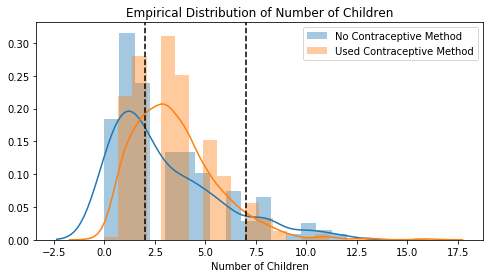

In [43]:
plt.figure(figsize=(8, 4))
sns.distplot(train_2.loc[(train_2["contraceptive"]==0) , "num_child"])
sns.distplot(train_2.loc[(train_2["contraceptive"]==1) , "num_child"])
plt.xlabel("Number of Children")
plt.title("Empirical Distribution of Number of Children")
plt.legend(labels=["No Contraceptive Method", "Used Contraceptive Method"]) 
plt.axvline(2, color='k', linestyle='dashed')
plt.axvline(7, color='k', linestyle='dashed')
plt.show();

### Result: Number of Children
1. Log transformed since it's right tail 
2. One Hot Encoding to 2 new Features 

In [55]:
# log transformed
temp['log_num_child'] = np.log(temp['num_child']+0.0000000001)

In [56]:
# add wife_education and husband_education together
temp['house_hold_education'] = temp['wife_education'] + temp['husband_education']

In [57]:
# preprocess for ohe 
temp['wife_education'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)
temp['husband_education'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)
temp['husband_occupation'].replace({1: "1", 2: "2", 3:"3", 4:"4"}, inplace=True)
temp['standard_living'].replace({1: "low", 2: "low_mid", 3:"mid", 4:"high"}, inplace=True)
temp['media_exposure'].replace({0:"Good", 1:"Not Good"}, inplace=True)

In [58]:
# one hot encoding all 
cols_ohe = ['wife_education', 'husband_education',
            'husband_occupation', 'standard_living', 'media_exposure']
for i in cols_ohe:
    temp = ohe(temp, i)
    temp.drop(i, axis = 1, inplace=True)

In [59]:
temp.columns

Index(['wife_age', 'num_child', 'wife_religion', 'wife_work', 'contraceptive',
       'age_indicator', 'age_indicator=22<age<44', 'age_indicator=age<= 22',
       'age_indicator=age>=44', 'log_num_child', 'house_hold_education',
       'wife_education=high', 'wife_education=low', 'wife_education=low_mid',
       'wife_education=mid', 'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid',
       'husband_occupation=1', 'husband_occupation=2', 'husband_occupation=3',
       'husband_occupation=4', 'standard_living=high', 'standard_living=low',
       'standard_living=low_mid', 'standard_living=mid', 'media_exposure=Good',
       'media_exposure=Not Good'],
      dtype='object')

### Barplot for Qualitative Data

<Figure size 1080x720 with 0 Axes>

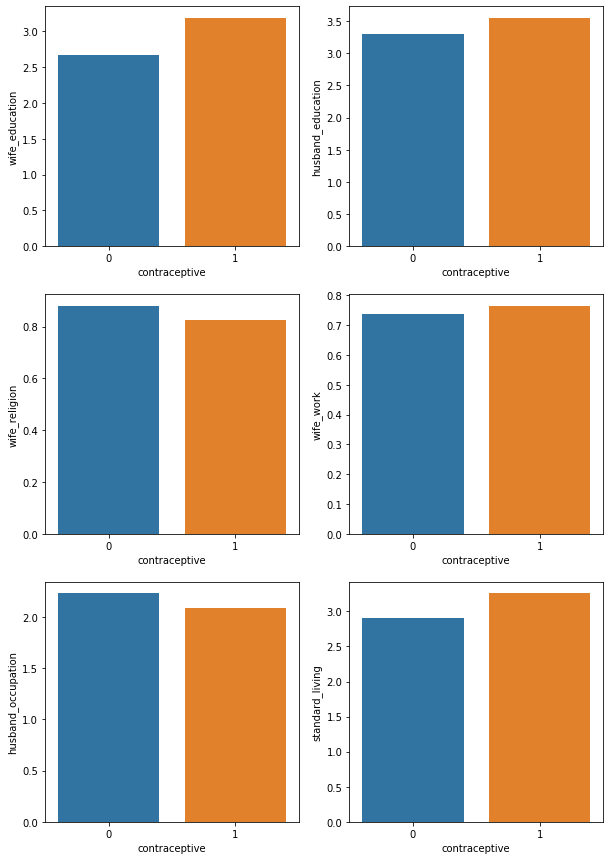

In [49]:
plt.figure(figsize=(15, 10))
col_names = list(train_2.columns.values)[1:]
col_names.pop(2)
col_names.pop(-1)
k = 2
fig1, axes = plt.subplots(int(np.ceil((len(col_names) - 1)/k)), k, figsize=(10,15))
for i in range(0, len(col_names) - 1):
    sns.barplot(x="contraceptive", y=col_names[i], data=train_2, 
                ax=axes[i//k][i%k], ci=None)

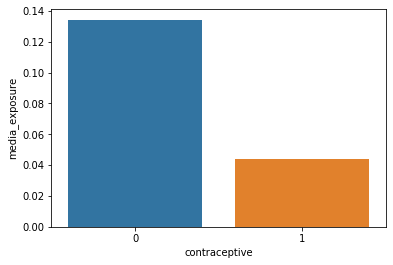

In [50]:
sns.barplot(x="contraceptive", y=col_names[-1], data=train_2, ci=None)

# Feature Engineering
1. Normalization 
2. Log transformed some features
3. Age seperate into bins
4. Drop Useless Features
5. Simplify Features Categories

# Model Building

## 1. Logistic Regression 

## 2. K-NN 

## 3. Random Forest

In [88]:
dat = temp.copy()
drop_cols = ['wife_age', 'age_indicator', 'age_indicator=age<= 22']
# drop_cols = ['age_indicator', 'age_indicator=age<= 22',
#              'age_indicator=22<age<44','age_indicator=age>=44','num_child']
for i in drop_cols:
    dat.drop(i,axis=1, inplace=True)
dat.columns

Index(['num_child', 'wife_religion', 'wife_work', 'contraceptive',
       'age_indicator=22<age<44', 'age_indicator=age>=44', 'log_num_child',
       'house_hold_education', 'wife_education=high', 'wife_education=low',
       'wife_education=low_mid', 'wife_education=mid',
       'husband_education=high', 'husband_education=low',
       'husband_education=low_mid', 'husband_education=mid',
       'husband_occupation=1', 'husband_occupation=2', 'husband_occupation=3',
       'husband_occupation=4', 'standard_living=high', 'standard_living=low',
       'standard_living=low_mid', 'standard_living=mid', 'media_exposure=Good',
       'media_exposure=Not Good'],
      dtype='object')

In [89]:
X_train_dat, X_test_dat,Y_train_dat,Y_test_dat = train_test_split(dat.drop('contraceptive', axis=1),
                                                  dat['contraceptive'], test_size=0.25, 
                                                  random_state=110)

print("Training Data Size:", {len(x_train)})
print("Test Data Size:", {len(x_test)})

Training Data Size: {1104}
Test Data Size: {369}


In [134]:
from sklearn.metrics import accuracy_score
# logistic regression based on raw features
# lr = LogisticRegression(fit_intercept=True)

lr = LogisticRegressionCV(Cs=4, fit_intercept=True, cv=15)
#lr = LogisticRegressionCV(np.linspace(1, 50, 200),  cv=15,max_iter=5000)

lr.fit(X_train_dat,Y_train_dat)
model_predicted_train = lr.predict(X_train_dat)
model_predicted_test = lr.predict(X_test_dat)
train_accuracy = accuracy_score(Y_train_dat, model_predicted_train)
test_accuracy = accuracy_score(Y_test_dat, model_predicted_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.6875
Test accuracy: 0.7236


## Confusion Matrix

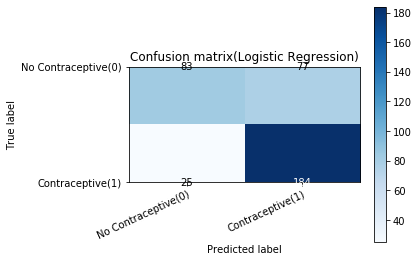

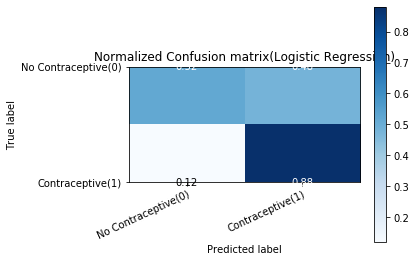

In [159]:
np.set_printoptions(precision=2)

lab_names = ["No Contraceptive(0)", "Contraceptive(1)"]
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test_dat.values, model_predicted_test, labels=lab_names,
                      title='Confusion matrix(Logistic Regression)')
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test_dat.values, model_predicted_test, labels=lab_names, normalize=True,
                      title='Normalized Confusion matrix(Logistic Regression)')

plt.show()

# KNN

In [92]:
from sklearn.neighbors import KNeighborsClassifier
# x_train, x_test,y_train,y_test = train_test_split(X,response, 
#                                                   test_size=0.25, random_state=2938)

In [140]:
# we fit a 2-NN classifier
n_neighbors = 28
knn = KNeighborsClassifier(n_neighbors, weights='uniform')
knn.fit(X_train_dat, Y_train_dat)
plt.show()
training_acc = knn.score(X_train_dat, Y_train_dat)
test_acc = knn.score(X_test_dat, Y_test_dat)
print(f"Train accuracy: {training_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.7101
Test accuracy: 0.7263


# Random Forest

In [424]:
data = pd.read_csv("final_proj_data/contraceptive/contraceptive_for_students.csv")
data['contraceptive'].replace({1: 0, 2: 1, 3: 1}, inplace=True)
train, test = train_test_split(data, test_size=0.25, random_state=100)
X_train = train.drop("contraceptive", axis = 1)
X_test = test.drop("contraceptive", axis = 1)
y_train = train["contraceptive"]
y_test = test["contraceptive"]

In [425]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_accuracy(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    accuracies = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        accuracies.append(model.score(X.iloc[va_ind,:], y.iloc[va_ind]))
    return np.mean(accuracies)

In [426]:
model = ensemble.RandomForestClassifier(n_estimators= 30)
#model.fit(X_train, y_train)
print ("Cross validation error with all features: " + str(cross_validate_accuracy(model, X_train, y_train)))

Cross validation error with all features: 0.6920032908268202


In [427]:
features = X_train.columns
features

Index(['wife_age', 'wife_education', 'husband_education', 'num_child',
       'wife_religion', 'wife_work', 'husband_occupation', 'standard_living',
       'media_exposure'],
      dtype='object')

In [428]:
for f in features:
    X_train_cur = X_train.copy()
    X_train_cur = X_train_cur.drop(f, axis = 1)
    print("Removing " + f + ": " + str(cross_validate_accuracy(model, X_train_cur, y_train)))

Removing wife_age: 0.6394529000411353
Removing wife_education: 0.6639284245166598
Removing husband_education: 0.6820115178938707
Removing num_child: 0.5905512134923899
Removing wife_religion: 0.6965281777046484
Removing wife_work: 0.6756972439325379
Removing husband_occupation: 0.6820197449609214
Removing standard_living: 0.6847511312217194
Removing media_exposure: 0.6865405183052242


In [429]:
# Removed husband_occupation
features_8 = features.copy()
features_8 = features_8.drop(["husband_occupation", "standard_living", "wife_religion"])
for f in features_8:
    X_train_cur = X_train.copy()
    X_train_cur = X_train_cur.drop(f, axis = 1)
    print("Removing " + f + ": " + str(cross_validate_accuracy(model, X_train_cur, y_train)))

Removing wife_age: 0.6304113533525297
Removing wife_education: 0.6711476758535582
Removing husband_education: 0.6901727684080624
Removing num_child: 0.587807486631016
Removing wife_work: 0.6856725627313862
Removing media_exposure: 0.6856355409296586


In [430]:
X_train_8 = X_train.drop(["husband_occupation", "standard_living", "wife_religion"], axis = 1)
cross_validate_accuracy(model, X_train_8, y_train)

0.6802180172768407

In [431]:
X_train["household_education"] = (X_train["wife_education"] + X_train["husband_education"] >= 6)
X_test["household_education"] = (X_test["wife_education"] + X_test["husband_education"] >= 6)

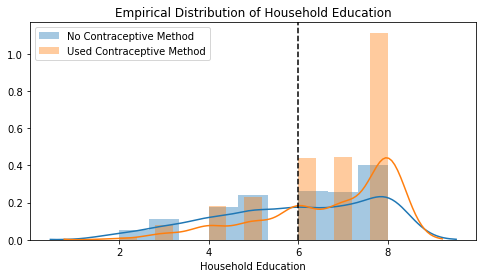

In [432]:
data["education"] = data["wife_education"] + data["husband_education"]
plt.figure(figsize=(8, 4))
sns.distplot(data.loc[(data["contraceptive"]==0) , "education"])
sns.distplot(data.loc[(data["contraceptive"]==1) , "education"])
plt.xlabel("Household Education")
plt.title("Empirical Distribution of Household Education")
plt.legend(labels=["No Contraceptive Method", "Used Contraceptive Method"]) 
plt.axvline(6, color='k', linestyle='dashed')
plt.show();

In [433]:
# Log num child vs num child
model = ensemble.RandomForestClassifier(n_estimators = 10)
X_train["log_num_child"] = np.log(X_train["num_child"] + 0.000001)
accuracy = []
for i in range(10):
    accuracy.append(cross_validate_accuracy(model, X_train[['num_child', 'wife_age', "household_education"]], y_train))
print("Num child: " + str(np.mean(accuracy)))

accuracy = []
for i in range(10):
    accuracy.append(cross_validate_accuracy(model, X_train[['log_num_child', 'wife_age', "household_education"]], y_train))
print("Log num child: " + str(np.mean(accuracy)))

Num child: 0.6903196215549157
Log num child: 0.6838013163307282


Log num child does not significantly improve the model in comparison to num child.

## Parameter tuning

In [434]:
# Use cross validation to tune random forest parameters
model = ensemble.RandomForestClassifier(n_estimators = 10)
cv_accuracy = cross_validate_accuracy(model, X_train[['num_child', 'wife_age', "household_education"]], y_train)
print("Baseline cross validation accuracy: " + str(cv_accuracy))

Baseline cross validation accuracy: 0.6802426984779926


### Tune number of estimators

In [435]:
# Tune number of estimators
num_estimators = np.arange(5, 105, 5)
cv_accuracies = []
X_train_columns = X_train[['num_child', 'wife_age', "household_education"]]
for n in num_estimators:
    model = ensemble.RandomForestClassifier(n_estimators = n)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

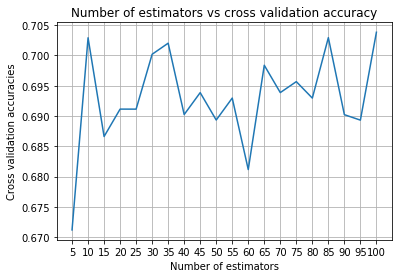

In [436]:
plt.plot(num_estimators, cv_accuracies)
plt.xticks(num_estimators)
plt.grid()
plt.title("Number of estimators vs cross validation accuracy")
plt.xlabel("Number of estimators")
plt.ylabel("Cross validation accuracies");

In [438]:
estimator = 35

### Tune max depth

In [439]:
# Tune max depth
depth = np.arange(5, 105, 10)
cv_accuracies = []
X_train_columns = X_train[['num_child', 'wife_age', "household_education"]]
for n in depth:
    model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = n)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

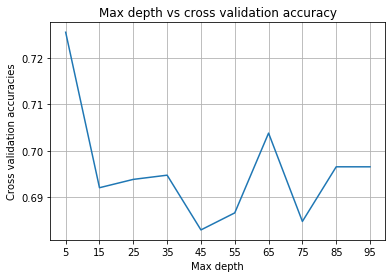

In [440]:
plt.plot(depth, cv_accuracies)
plt.xticks(depth)
plt.grid()
plt.title("Max depth vs cross validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Cross validation accuracies");

In [441]:
# Tune max depth from 1 to 15
depth = np.linspace(1, 15, 15)
cv_accuracies = []
X_train_columns = X_train[['num_child', 'wife_age', "household_education"]]
for n in depth:
    model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = n)
    cv_accuracies.append(cross_validate_accuracy(model, X_train_columns, y_train))

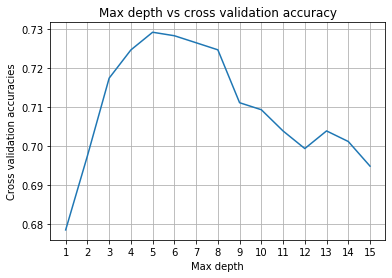

In [442]:
plt.plot(depth, cv_accuracies)
plt.xticks(depth)
plt.grid()
plt.title("Max depth vs cross validation accuracy")
plt.xlabel("Max depth")
plt.ylabel("Cross validation accuracies");

In [443]:
best_depth = 9
model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = best_depth)
cross_validate_accuracy(model, X_train_columns, y_train)

0.7110695187165776

In [444]:
model = ensemble.RandomForestClassifier(n_estimators = estimator, max_depth = best_depth)
X_test["household_education"] = (X_test["wife_education"] + X_test["husband_education"] >= 6)
scores = []
for i in range(5):
    model.fit(X_train_columns, y_train)
    scores.append(model.score(X_test[['num_child', 'wife_age', "household_education"]], y_test))
np.mean(scores)

0.6953929539295393